# **Notebooks sequence;)**
* Train-val split notebook [here](https://www.kaggle.com/chamecall/train-val-split).<br>
* Pretrain roberta-base on mlm with the competition data notebook [here](https://www.kaggle.com/chamecall/clrp-pretrain).<br>
* Finetune pretrained roberta-base on readability task notebook [*CURRENT ONE*].<br>
* Inference model notebook [here](https://www.kaggle.com/chamecall/clrp-inference).<br>

# **Credits**<br>
*The notebooks series was influenced by the following works: *
* https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
* https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune
* https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-fit
* https://www.kaggle.com/andretugan/pre-trained-roberta-solution-in-pytorch

In [1]:
from IPython.core.magic import register_cell_magic
import os
from pathlib import Path

## define custom magic to save most useful classes and use them in inference notebook 
## instead of copying the code every time you have changes in the classes
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)
    
Path('/kaggle/working/scripts').mkdir(exist_ok=True)
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(exist_ok=True)

In [2]:
%%write_and_run scripts/imports.py

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler, Sampler
from torch.nn.functional import mse_loss
from transformers import AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup, AutoConfig, AdamW

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
# print(plt.style.available)
from time import time
from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
g_ = Fore.GREEN
y_ = Fore.YELLOW
w_ = Fore.WHITE
bb_ = Back.BLACK
sr_ = Style.RESET_ALL



In [3]:
%%write_and_run scripts/config.py

class Config:
    model_name = 'roberta-base'
    pretrained_model_path = '../input/clrp-pretrain/clrp_roberta_base'
    output_hidden_states = True
    epochs = 3
    evaluate_interval = 10
    batch_size = 16
    device = 'cuda'
    seed = 42
    max_len = 256
    lr = 2e-5
    wd = 0.01
    eval_schedule = [(float('inf'), 16), (0.5, 8), (0.49, 4), (0.48, 2), (0.47, 1), (0, 0)]

    

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=Config.seed)

In [5]:
# train_df = pd.read_csv('../input/k/chamecall/train-val-split/train.csv')
# val_df = pd.read_csv('../input/k/chamecall/train-val-split/val.csv')

kfold_df = pd.read_csv('../input/k/chamecall/train-val-split/kfold.csv')
# aux_df = pd.read_csv('../input/clrauxdata/aux_data_embed.csv', index_col='index', converters={'aux_text': eval})

In [6]:
%%write_and_run scripts/dataset.py

from torch.utils.data import Dataset
import torch

def convert_examples_to_features(text, tokenizer, max_len):

    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        truncation=True,
        padding='max_length',
    )
    return tok


class CLRPDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.tolist()
        if not is_test:
            self.targets = self.data.target.tolist()
            
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:
            excerpt = self.excerpts[item]
            label = self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

In [7]:
%%write_and_run scripts/model.py

import torch
import torch.nn as nn


class AttentionHead(nn.Module):
    def __init__(self, h_size, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(h_size, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class CLRPModel(nn.Module):
    def __init__(self,transformer,config):
        super(CLRPModel,self).__init__()
        self.h_size = config.hidden_size
        self.transformer = transformer
        self.head = AttentionHead(self.h_size)
        self.linear = nn.Linear(self.h_size, 1)
              
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer(input_ids, attention_mask)
        x = self.head(transformer_out.last_hidden_state)
        x = self.linear(x)
        return x

    


In [8]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]    
    attention_parameters = named_parameters[199:203]
    regressor_parameters = named_parameters[203:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = Config.lr

        if layer_num >= 69:        
            lr = Config.lr * 2.5

        if layer_num >= 133:
            lr = Config.lr * 5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return optim.AdamW(parameters)

In [9]:

class AvgCounter:
    def __init__(self):
        self.reset()
        
    def update(self, loss, n_samples):
        self.loss += loss * n_samples
        self.n_samples += n_samples
        
    def avg(self):
        return self.loss / self.n_samples
    
    def reset(self):
        self.loss = 0
        self.n_samples = 0

class EvaluationScheduler:
    def __init__(self, evaluation_schedule, penalize_factor=1, max_penalty=8):
        self.evaluation_schedule = evaluation_schedule
        self.evaluation_interval = self.evaluation_schedule[0][1]
        self.last_evaluation_step = 0
        self.prev_loss = float('inf')
        self.penalize_factor = penalize_factor
        self.penalty = 0
        self.prev_interval = -1
        self.max_penalty = max_penalty

    def step(self, step):
        # should we to make evaluation right now
        if step >= self.last_evaluation_step + self.evaluation_interval:
            self.last_evaluation_step = step
            return True
        else:
            return False
        
            
    def update_evaluation_interval(self, last_loss):
        # set up evaluation_interval depending on loss value
        cur_interval = -1
        for i, (loss, interval) in enumerate(self.evaluation_schedule[:-1]):
            if self.evaluation_schedule[i+1][0] < last_loss < loss:
                self.evaluation_interval = interval
                cur_interval = i
                break
#         if last_loss > self.prev_loss and self.prev_interval == cur_interval:
#             self.penalty += self.penalize_factor
#             self.penalty = min(self.penalty, self.max_penalty)
#             self.evaluation_interval += self.penalty
#         else:
#             self.penalty = 0
            
        self.prev_loss = last_loss
        self.prev_interval = cur_interval
        
          
        
def make_dataloader(data, tokenizer, is_train=True):
    dataset = CLRPDataset(data, tokenizer=tokenizer, max_len=Config.max_len)
    if is_train:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    batch_dataloader = DataLoader(dataset, sampler=sampler, batch_size=Config.batch_size, pin_memory=True)
    return batch_dataloader
                   
            
class Trainer:
    def __init__(self, train_dl, val_dl, model, optimizer, scheduler, criterion, model_num):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = Config.device
        self.batches_per_epoch = len(self.train_dl)
        self.criterion = criterion
        self.model_num = model_num
                
    def run(self):
        record_info = {
            'train_loss': [],
            'val_loss': [],
        }
        
        best_val_loss = float('inf')
        evaluation_scheduler = EvaluationScheduler(Config.eval_schedule)
        train_loss_counter = AvgCounter()
        step = 0
        
        for epoch in range(Config.epochs):
            
            print(f'{r_}Epoch: {epoch+1}/{Config.epochs}{sr_}')
            start_epoch_time = time()
            
            for batch_num, batch in enumerate(self.train_dl):
                train_loss = self.train(batch)
#                 print(f'{epoch+1}#[{step+1}/{len(self.train_dl)}]: train loss - {train_loss.item()}')

                train_loss_counter.update(train_loss, len(batch))
                record_info['train_loss'].append((step, train_loss.item()))

                if evaluation_scheduler.step(step):
                    val_loss = self.evaluate()
                    
                    record_info['val_loss'].append((step, val_loss.item()))        
                    print(f'\t\t{epoch+1}#[{batch_num+1}/{self.batches_per_epoch}]: train loss - {train_loss_counter.avg()} | val loss - {val_loss}',)
                    train_loss_counter.reset()

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        print(f"\t\t{g_}Val loss decreased from {best_val_loss} to {val_loss}{sr_}")
                        torch.save(self.model, models_dir / f'best_model_{self.model_num}.pt')
                        
                    evaluation_scheduler.update_evaluation_interval(val_loss.item())
                        

                step += 1
            end_epoch_time = time()
            print(f'{bb_}{y_}The epoch took {end_epoch_time - start_epoch_time} sec..{sr_}')

        return record_info, best_val_loss
            

    def train(self, batch):
        self.model.train()
        sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device), 
        self.model.zero_grad() 
        preds = self.model(sent_id, mask)
        train_loss = self.criterion(preds, labels.unsqueeze(1))
        
        train_loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        return torch.sqrt(train_loss)

    def evaluate(self):
        self.model.eval()
        val_loss_counter = AvgCounter()

        for step,batch in enumerate(self.val_dl):
            sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
            with torch.no_grad():
                preds = self.model(sent_id, mask)
                loss = self.criterion(preds,labels.unsqueeze(1))
                val_loss_counter.update(torch.sqrt(loss), len(labels))
        return val_loss_counter.avg()
    
    
def mse_loss(y_true,y_pred):
    return nn.functional.mse_loss(y_true,y_pred)

  Model#1  


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-pretrain/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/3
		1#[17/142]: train loss - 1.38238525390625 | val loss - 1.0201274156570435
		Val loss decreased from 1.0201274156570435 to 1.0201274156570435
		1#[33/142]: train loss - 0.9020563364028931 | val loss - 0.7760196924209595
		Val loss decreased from 0.7760196924209595 to 0.7760196924209595
		1#[49/142]: train loss - 0.6836601495742798 | val loss - 0.5916534066200256
		Val loss decreased from 0.5916534066200256 to 0.5916534066200256
		1#[65/142]: train loss - 0.6438389420509338 | val loss - 0.6647652983665466
		1#[81/142]: train loss - 0.6173423528671265 | val loss - 0.5938512086868286
		1#[97/142]: train loss - 0.6258863210678101 | val loss - 0.578776478767395
		Val loss decreased from 0.578776478767395 to 0.578776478767395
		1#[113/142]: train loss - 0.592172384262085 | val loss - 0.4857524335384369
		Val loss decreased from 0.4857524335384369 to 0.4857524335384369
		1#[117/142]: train loss - 0.38564765453338623 | val loss - 0.47935131192207336
		Val loss decreased from 0.4793

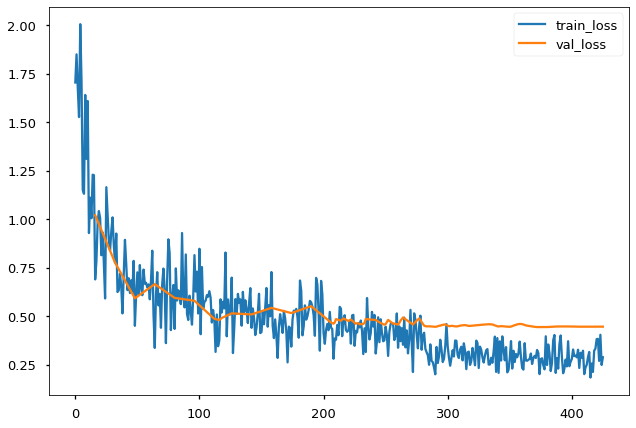

  Model#2  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-pretrain/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/3
		1#[17/142]: train loss - 1.1660367250442505 | val loss - 0.8776522874832153
		Val loss decreased from 0.8776522874832153 to 0.8776522874832153
		1#[33/142]: train loss - 0.7582911252975464 | val loss - 0.7187586426734924
		Val loss decreased from 0.7187586426734924 to 0.7187586426734924
		1#[49/142]: train loss - 0.6521456241607666 | val loss - 0.634502112865448
		Val loss decreased from 0.634502112865448 to 0.634502112865448
		1#[65/142]: train loss - 0.6176349520683289 | val loss - 0.5916978120803833
		Val loss decreased from 0.5916978120803833 to 0.5916978120803833
		1#[81/142]: train loss - 0.6444885730743408 | val loss - 0.6135448813438416
		1#[97/142]: train loss - 0.5865969061851501 | val loss - 0.5406083464622498
		Val loss decreased from 0.5406083464622498 to 0.5406083464622498
		1#[113/142]: train loss - 0.5384031534194946 | val loss - 0.5727260708808899
		1#[129/142]: train loss - 0.5764583349227905 | val loss - 0.6038148999214172
The epoch took 106.557268142700

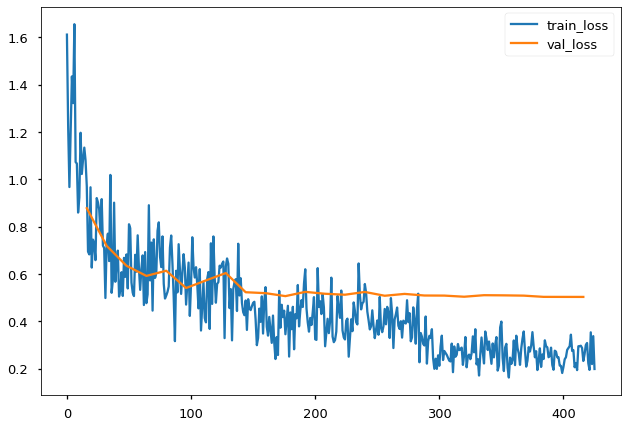

  Model#3  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-pretrain/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/3
		1#[17/142]: train loss - 1.307112455368042 | val loss - 0.9881435632705688
		Val loss decreased from 0.9881435632705688 to 0.9881435632705688
		1#[33/142]: train loss - 0.9181971549987793 | val loss - 0.7144840359687805
		Val loss decreased from 0.7144840359687805 to 0.7144840359687805
		1#[49/142]: train loss - 0.7589818239212036 | val loss - 0.8471406102180481
		1#[65/142]: train loss - 0.7312214374542236 | val loss - 0.6585687398910522
		Val loss decreased from 0.6585687398910522 to 0.6585687398910522
		1#[81/142]: train loss - 0.5608718991279602 | val loss - 0.5598616600036621
		Val loss decreased from 0.5598616600036621 to 0.5598616600036621
		1#[97/142]: train loss - 0.6046206951141357 | val loss - 0.7184579372406006
		1#[113/142]: train loss - 0.6044151186943054 | val loss - 0.6069976091384888
		1#[129/142]: train loss - 0.5613861083984375 | val loss - 0.535362958908081
		Val loss decreased from 0.535362958908081 to 0.535362958908081
The epoch took 107.1361930370330

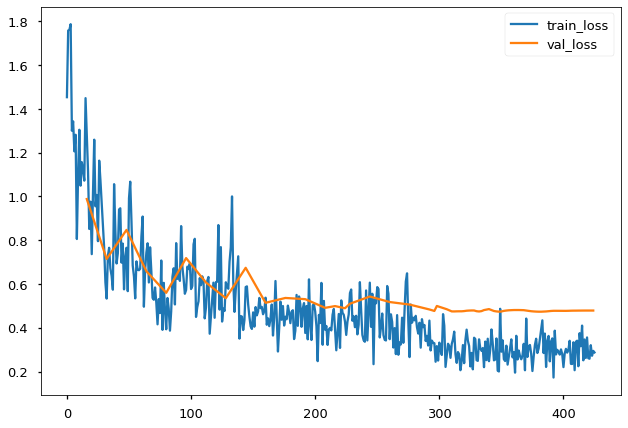

  Model#4  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-pretrain/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/3
		1#[17/142]: train loss - 1.0577497482299805 | val loss - 0.8996861577033997
		Val loss decreased from 0.8996861577033997 to 0.8996861577033997
		1#[33/142]: train loss - 0.782164990901947 | val loss - 0.6781256198883057
		Val loss decreased from 0.6781256198883057 to 0.6781256198883057
		1#[49/142]: train loss - 0.6438940167427063 | val loss - 0.6387052536010742
		Val loss decreased from 0.6387052536010742 to 0.6387052536010742
		1#[65/142]: train loss - 0.5919495820999146 | val loss - 0.6174968481063843
		Val loss decreased from 0.6174968481063843 to 0.6174968481063843
		1#[81/142]: train loss - 0.5682432651519775 | val loss - 0.6611262559890747
		1#[97/142]: train loss - 0.5337364077568054 | val loss - 0.5390072464942932
		Val loss decreased from 0.5390072464942932 to 0.5390072464942932
		1#[113/142]: train loss - 0.6125189661979675 | val loss - 0.5200598239898682
		Val loss decreased from 0.5200598239898682 to 0.5200598239898682
		1#[129/142]: train loss - 0.55971384048

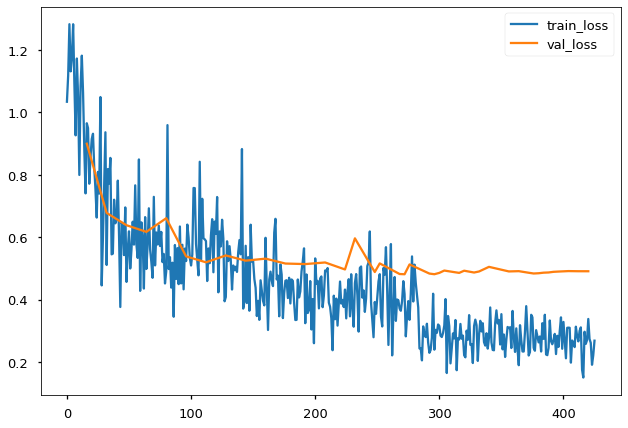

  Model#5  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-pretrain/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/3
		1#[17/142]: train loss - 1.2207238674163818 | val loss - 0.9341468214988708
		Val loss decreased from 0.9341468214988708 to 0.9341468214988708
		1#[33/142]: train loss - 0.8080788850784302 | val loss - 0.6856980919837952
		Val loss decreased from 0.6856980919837952 to 0.6856980919837952
		1#[49/142]: train loss - 0.6702651381492615 | val loss - 0.6377453804016113
		Val loss decreased from 0.6377453804016113 to 0.6377453804016113
		1#[65/142]: train loss - 0.6825214624404907 | val loss - 0.6028012037277222
		Val loss decreased from 0.6028012037277222 to 0.6028012037277222
		1#[81/142]: train loss - 0.5678921937942505 | val loss - 0.5499730110168457
		Val loss decreased from 0.5499730110168457 to 0.5499730110168457
		1#[97/142]: train loss - 0.5861427187919617 | val loss - 0.5726810693740845
		1#[113/142]: train loss - 0.5301182270050049 | val loss - 0.5274100303649902
		Val loss decreased from 0.5274100303649902 to 0.5274100303649902
		1#[129/142]: train loss - 0.5835180282

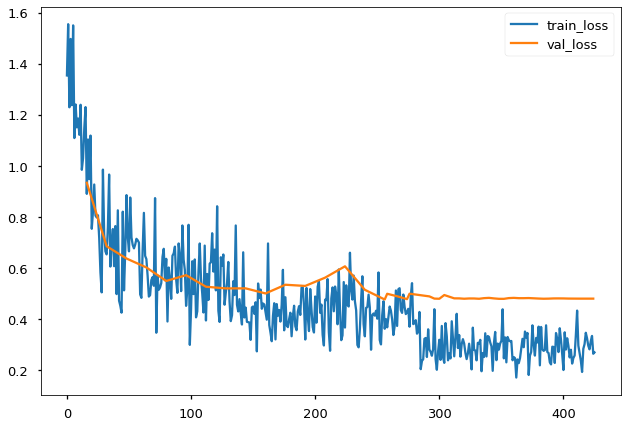

Best val losses: [tensor(0.4432, device='cuda:0'), tensor(0.5030, device='cuda:0'), tensor(0.4736, device='cuda:0'), tensor(0.4818, device='cuda:0'), tensor(0.4774, device='cuda:0')]


In [10]:
best_scores = []

for model_num in range(5): 
    print(f'{bb_}{w_}  Model#{model_num+1}  {sr_}')

    tokenizer = AutoTokenizer.from_pretrained(Config.model_name)
    config = AutoConfig.from_pretrained(Config.pretrained_model_path)
    config.update({
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
            }) 

    train_dl = make_dataloader(kfold_df[kfold_df.fold!=model_num], tokenizer)
    val_dl = make_dataloader(kfold_df[kfold_df.fold==model_num], tokenizer, is_train=False)

#     train_dl = make_dataloader(train_df, tokenizer)
#     val_dl = make_dataloader(val_df, tokenizer, is_train=False)

    transformer = AutoModel.from_pretrained(Config.pretrained_model_path, config=config)  
    model = CLRPModel(transformer, config)
    model = model.to(Config.device)
    optimizer = create_optimizer(model)
    scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_training_steps=Config.epochs * len(train_dl),
            num_warmup_steps=50)  

    criterion = mse_loss

    trainer = Trainer(train_dl, val_dl, model, optimizer, scheduler, criterion, model_num)
    record_info, best_val_loss = trainer.run()
    best_scores.append(best_val_loss)    
    
    steps, train_losses = list(zip(*record_info['train_loss']))
    plt.plot(steps, train_losses, label='train_loss')
    steps, val_losses = list(zip(*record_info['val_loss']))
    plt.plot(steps, val_losses, label='val_loss')
    plt.legend()
    plt.show()
    
print('Best val losses:', best_scores)
# print('Avg val loss:', np.array(best_scores).mean())
!date '+%A %W %Y %X' > execution_time